In [1]:
import numpy as np
import torch
from torch_geometric.utils import to_networkx

from networkx import single_source_dijkstra
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib.colors import Normalize

from data import load_terrain_grid, grid_to_mesh, ShortestPathDataset

/home/haoyun/miniconda3/envs/rfm/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/home/haoyun/miniconda3/envs/rfm/lib/python3.13/site-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


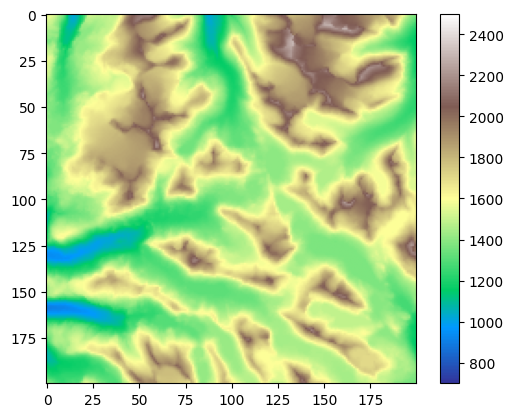

In [2]:
terrain = load_terrain_grid(200)
norm = Normalize(vmin=700, vmax=2500)
plt.imshow(terrain[:, :, 2], cmap="terrain", norm=norm, origin="upper")
plt.colorbar()

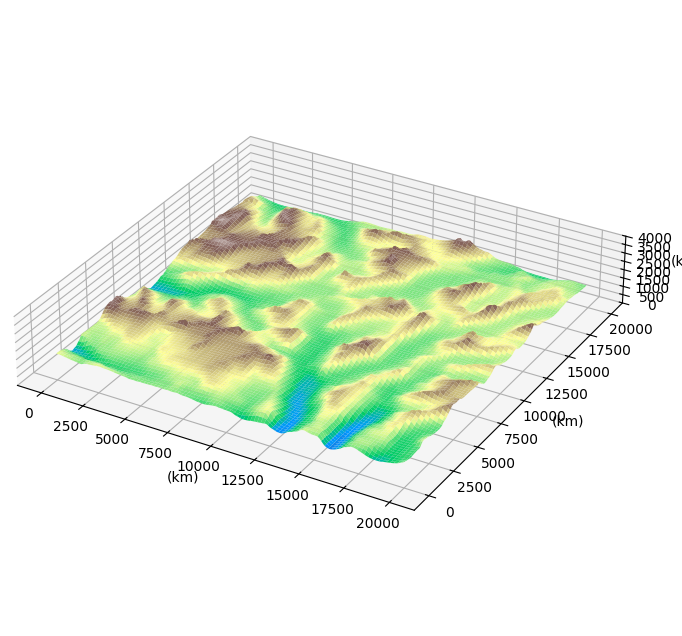

In [4]:
fig, ax = plt.subplots(figsize=(8,8),subplot_kw=dict(projection='3d'))

ax.plot_surface(terrain[:, :, 0], terrain[:, :, 1], terrain[:, :, 2], cmap="terrain",
                        rcount=100, ccount=100, norm=norm)
ax.set_xlabel("(km)")
ax.set_ylabel("(km)")
ax.set_zlabel("(km)")
ax.set_zlim([0, 4000])
ax.set_aspect('equal')

fig.savefig("./output/terrain.png", dpi=200)


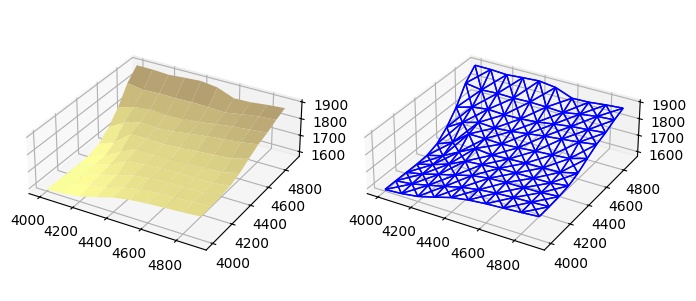

In [7]:
# Now let's build the terrain mesh

mesh = grid_to_mesh(terrain, add_diag=True)
nx_mesh = to_networkx(mesh, node_attrs=["pos"], edge_attrs=['weight'], to_undirected=True)


# Check if the mesh is correct
fig, axs = plt.subplots(1, 2, figsize=(8,4),subplot_kw=dict(projection='3d'))
window = [40, 40, 50, 50]
N = terrain.shape[0]
vertices = np.arange(N * N).reshape((N, N))
indices_in_window = vertices[window[0]:window[2], window[1]:window[3]].flatten()

submesh = mesh.subgraph(torch.from_numpy(indices_in_window))
subterrain = submesh.pos.reshape((window[2] - window[0], window[3] - window[1], 3))
mesh_edges = submesh.pos[submesh.edge_index.T]

axs[0].plot_surface(subterrain[:, :, 0], subterrain[:, :, 1], subterrain[:, :, 2], cmap="terrain",
                        rcount=100, ccount=100, norm=norm)
axs[0].set_aspect("equal")
lc = Line3DCollection(mesh_edges, colors='blue', linewidths=1)
axs[1].add_collection3d(lc)
axs[1].set_aspect("equal")


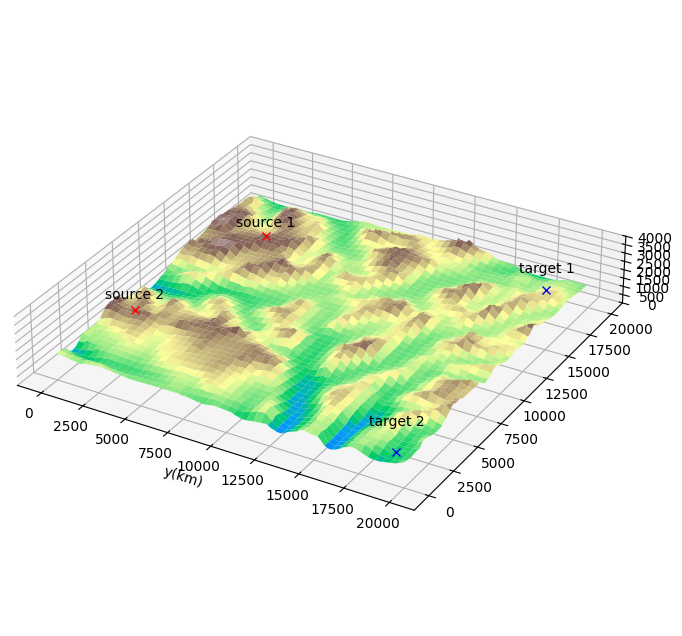

In [10]:
# choose two diagonal query
source_1 = (33, 150)#(15, 50)
target_1 = (185, 180)
source_2 = (15, 50)
target_2 = (190, 10)


N = terrain.shape[0]
vertices = np.arange(N * N).reshape((N, N))
demo1 = vertices[*source_1].item(), vertices[*target_1].item()
demo2 = vertices[*source_2].item(), vertices[*target_2].item()

distance1, path1 = single_source_dijkstra(nx_mesh, demo1[0], )
distance2, path2 = single_source_dijkstra(nx_mesh, demo2[0], )

distance1_mat = torch.FloatTensor([distance1[i] for i in range(N * N)]).reshape((N, N))

# Show the points
fig, ax = plt.subplots(figsize=(8,8),subplot_kw=dict(projection='3d'))

ax.plot_surface(terrain[:, :, 0], terrain[:, :, 1], terrain[:, :, 2], cmap="terrain",
                        rcount=60, ccount=60, norm=norm)

ax.plot(*terrain[*source_1], marker="x",color="r",  zorder=10)
ax.text(*terrain[*source_1, :2], terrain[*source_1, 2] + 600, "source 1", zorder=10, horizontalalignment="center")
ax.plot(*terrain[*target_1], marker="x",color="b",  zorder=10)
ax.text(*terrain[*target_1, :2], terrain[*source_1, 2] + 600, "target 1", zorder=10, horizontalalignment="center")
ax.plot(*terrain[*source_2], marker="x",color="r",  zorder=10)
ax.text(*terrain[*source_2, :2], terrain[*source_1, 2] + 600, "source 2", zorder=10, horizontalalignment="center")
ax.plot(*terrain[*target_2], marker="x",color="b",  zorder=10)
ax.text(*terrain[*target_2, :2], terrain[*source_1, 2] + 600, "target 2", zorder=10, horizontalalignment="center")

ax.set_zlim([0, 4000])
ax.set_xlabel("x(km)")
ax.set_xlabel("y(km)")

ax.set_aspect('equal')

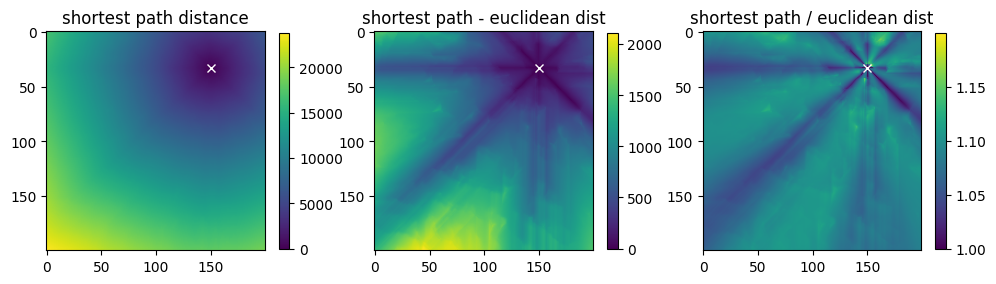

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

euclidean_dist = (terrain - terrain[*source_1]).norm(p=2, dim=-1)
axs[0].plot(source_1[1], source_1[0], marker="x", color="w")
img = axs[0].imshow(distance1_mat, )
axs[0].set_title("shortest path distance")
fig.colorbar(mappable=None, cmap=img.cmap, norm=img.norm, ax=axs[0], shrink=0.7)

axs[1].plot(source_1[1], source_1[0], marker="x", color="w")
img = axs[1].imshow(distance1_mat - euclidean_dist)
axs[1].set_title("shortest path - euclidean dist")
fig.colorbar(mappable=None, cmap=img.cmap, norm=img.norm, ax=axs[1], shrink=0.7)

axs[2].plot(source_1[1], source_1[0], marker="x", color="w")
img = axs[2].imshow((distance1_mat+1e-5) / (euclidean_dist+1e-5))
axs[2].set_title("shortest path / euclidean dist")
fig.colorbar(mappable=None, cmap=img.cmap, norm=img.norm, ax=axs[2], shrink=0.7)

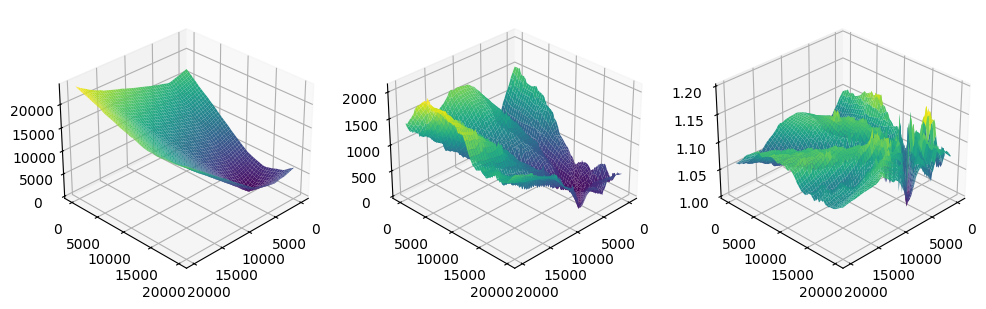

In [12]:
fig, axs = plt.subplots(1, 3, figsize=(12,4),subplot_kw=dict(projection='3d'))

axs[0].plot_surface(terrain[:, :, 0], terrain[:, :, 1], distance1_mat, cmap="viridis",
                        rcount=60, ccount=60)
axs[1].plot_surface(terrain[:, :, 0], terrain[:, :, 1], distance1_mat - euclidean_dist, cmap="viridis",
                        rcount=60, ccount=60)
axs[2].plot_surface(terrain[:, :, 0], terrain[:, :, 1], (distance1_mat+1e-5) / (euclidean_dist+1e-5), cmap="viridis",
                        rcount=60, ccount=60)
for i in range(3):
    axs[i].view_init(azim=45)


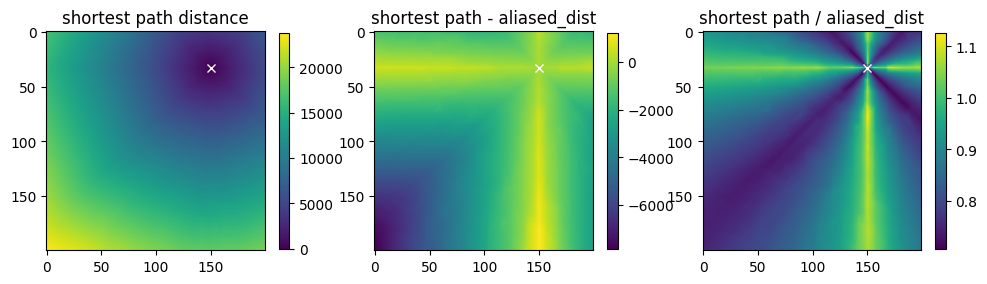

In [ ]:
# Some idea about invariance and scale out

fig, axs = plt.subplots(1, 3, figsize=(12, 4))

xy_l1 = (terrain[:, :, :2] - terrain[*source_1,:2]).norm(p=1, dim=-1)
z_dist = (terrain[:, :, 2] - terrain[*source_1, 2]).abs()
aliased_dist = (z_dist ** 2 + xy_l1 ** 2) ** 0.5

axs[0].plot(source_1[1], source_1[0], marker="x", color="w")
img = axs[0].imshow(distance1_mat)
axs[0].set_title("shortest path distance")
fig.colorbar(mappable=None, cmap=img.cmap, norm=img.norm, ax=axs[0], shrink=0.7)

axs[1].plot(source_1[1], source_1[0], marker="x", color="w")
img = axs[1].imshow(distance1_mat - aliased_dist)
axs[1].set_title("shortest path - aliased_dist")
fig.colorbar(mappable=None, cmap=img.cmap, norm=img.norm, ax=axs[1], shrink=0.7)

axs[2].plot(source_1[1], source_1[0], marker="x", color="w")
img = axs[2].imshow((distance1_mat+1e-5)/ (aliased_dist+1e-5))
axs[2].set_title("shortest path / aliased_dist")
fig.colorbar(mappable=None, cmap=img.cmap, norm=img.norm, ax=axs[2], shrink=0.7)

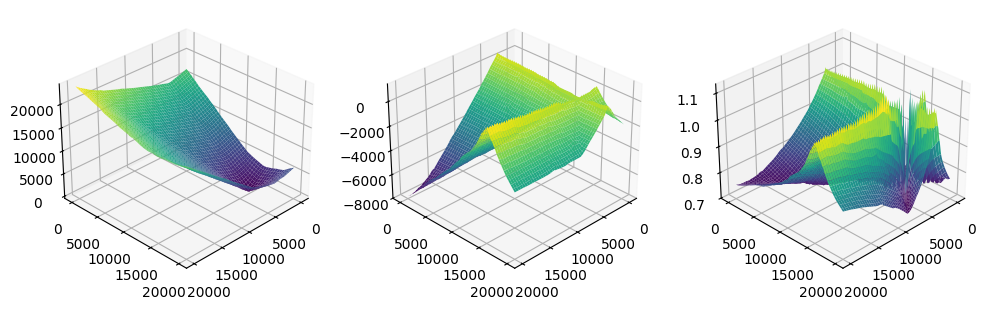

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(12,4),subplot_kw=dict(projection='3d'))

axs[0].plot_surface(terrain[:, :, 0], terrain[:, :, 1], distance1_mat, cmap="viridis",
                        rcount=60, ccount=60)
axs[1].plot_surface(terrain[:, :, 0], terrain[:, :, 1], distance1_mat - aliased_dist, cmap="viridis",
                        rcount=60, ccount=60)
axs[2].plot_surface(terrain[:, :, 0], terrain[:, :, 1], (distance1_mat + 1e-5) / (aliased_dist+1e-5), cmap="viridis",
                        rcount=60, ccount=60)

for i in range(3):
    axs[i].view_init(azim=45)

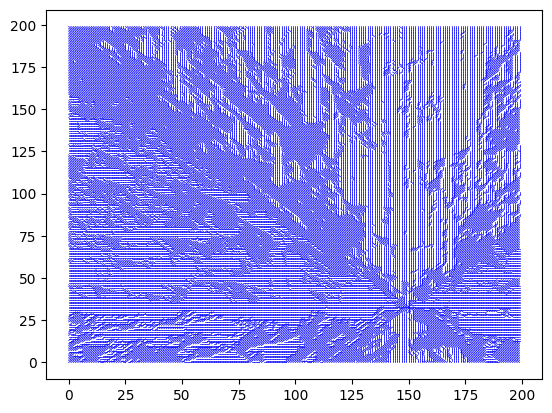

<Figure size 800x800 with 0 Axes>

In [ ]:
# Shortest path tree

shortest_path_tree = []
flatten_terrain_coord = terrain[:, :, 2].reshape((-1, 2))

for i in range(40000):
    if i != vertices[*source_1]:
        shortest_path_tree.append((path1[i][-2] % 200, path1[i][-2] // 200, i % 200, i // 200))

shortest_path_tree = np.array(shortest_path_tree)

plt.plot([shortest_path_tree[:,0], shortest_path_tree[:,2]], 
         [shortest_path_tree[:,1], shortest_path_tree[:,3]], 
         'b-', linewidth=0.5)
plt.figure(figsize=(8,8))
plt.show()

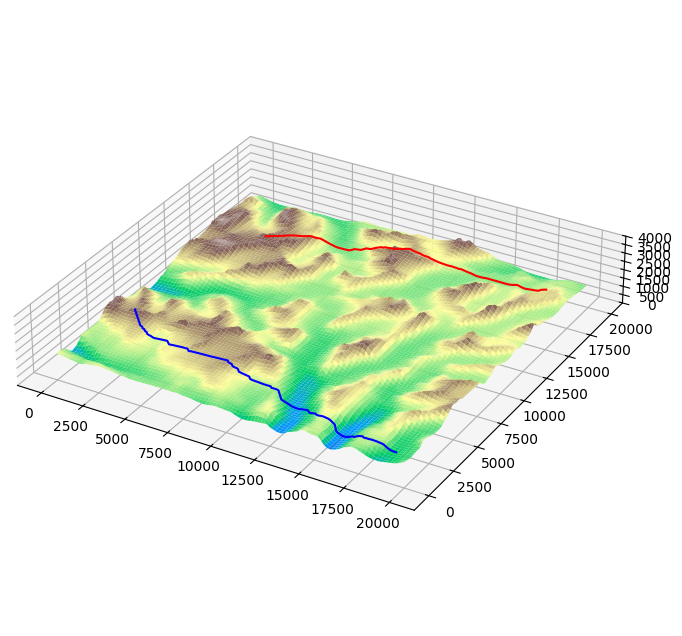

In [ ]:
# Visualizing the path

p1 = path1[demo1[1]]
p2 = path2[demo2[1]]
p1_coord = terrain.reshape((-1, 3))[p1]
p2_coord = terrain.reshape((-1, 3))[p2]


fig, ax = plt.subplots(figsize=(8,8),subplot_kw=dict(projection='3d'))

ax.plot_surface(terrain[:, :, 0], terrain[:, :, 1], terrain[:, :, 2], cmap="terrain",
                        rcount=100, ccount=100, norm=norm)

# let the trajectory float slightly above the terrain
ax.plot(p1_coord[:, 0], p1_coord[:, 1], p1_coord[:, 2]+1, color="r", zorder=10)
ax.plot(p2_coord[:, 0], p2_coord[:, 1], p2_coord[:, 2]+1, color="b", zorder=10)

ax.set_zlim([0, 4000])
ax.set_aspect('equal')


## Remark

Constructing a grid mesh introduce significant error.
It seems that we should consider the PDE based geodesic distance groundtruth would be better.

But the major goal is TDA, I should not go down the rabbit hole.

# Part2 TDA analysis

Text(0.5, 0.01, 'estimated dim = 2.00379')

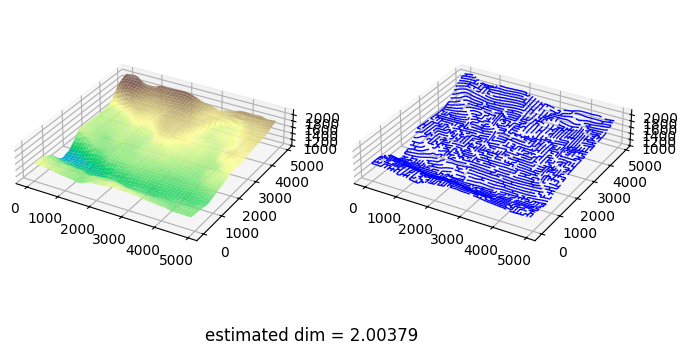

In [18]:
terrain = load_terrain_grid(res=200)
window = [0, 0, 50, 50]
indices_in_window = vertices[window[0]:window[2], window[1]:window[3]].flatten()

mesh = grid_to_mesh(terrain)
submesh = mesh.subgraph(torch.from_numpy(indices_in_window))
subterrain = submesh.pos.reshape((50, 50, 3))

# Build MST
from networkx import minimum_spanning_tree
nx_submesh = to_networkx(submesh, edge_attrs=['weight'], to_undirected=True)
T = minimum_spanning_tree(nx_submesh)
edges = np.array(T.edges())
tree_seg = submesh.pos[edges]

fig, axs = plt.subplots(1, 2, figsize=(8,4),subplot_kw=dict(projection='3d'))
axs[0].plot_surface(subterrain[:, :, 0], subterrain[:, :, 1], subterrain[:, :, 2], cmap="terrain",
                        rcount=100, ccount=100, norm=norm)
axs[0].set_aspect("equal")

lc = Line3DCollection(tree_seg, colors='blue', linewidths=1)
axs[1].add_collection3d(lc)
axs[1].set_aspect("equal")
fig.supxlabel("estimated dim = 2.00379")


In [16]:
terrain = load_terrain_grid(res=400)
window = [0, 0, 100, 100]
indices_in_window = vertices[window[0]:window[2], window[1]:window[3]].flatten()

mesh = grid_to_mesh(terrain)
submesh = mesh.subgraph(torch.from_numpy(indices_in_window))
subterrain = submesh.pos.reshape((100, 100, 3))

# Build MST
from networkx import minimum_spanning_tree
nx_submesh = to_networkx(submesh, edge_attrs=['weight'], to_undirected=True)
T2 = minimum_spanning_tree(nx_submesh)
edges2 = np.array(T.edges())


In [ ]:
pw_sum = sum(x[2]["weight"] for x in T.edges(data=True)) / 5000
beta = np.log(pw_sum) / np.log(2500)
print(f"Power weighted {pw_sum}")
print(f"beta = {beta}")
print(f"estimated dim = {1 / (1 - beta)}")


Power weighted 50.371604371643066
beta = 0.5009463908496885
estimated dim = 2.003792742231841


In [ ]:
sum(x[2]["weight"] for x in T.edges(data=True)) / 

251858.02185821533

### Analysis

$$
\beta = \lim\sup_{n\to\infty} \frac{\log\mathbb E [E_0^1(x_1, ..., x_n)]}{\log (n)}
$$
Somehow, computing the PH dimension still feel somehow wrong:

(1) We are using a fix resolution terrain, so we kind of ignore the fractual nature of the terrain.
(On the other hand, if the terrain is fractual, the geodesic distance goes to infinity.)

(2) It is not straightfoward how to deal with the scale. Scale is the constant inside the dimension estimation, and reduce to 0 when n goes to infinity. But with a relatively small n it is unclear how to deal with the scale.

Anyway lets try how this distinguish different landscape complexity.

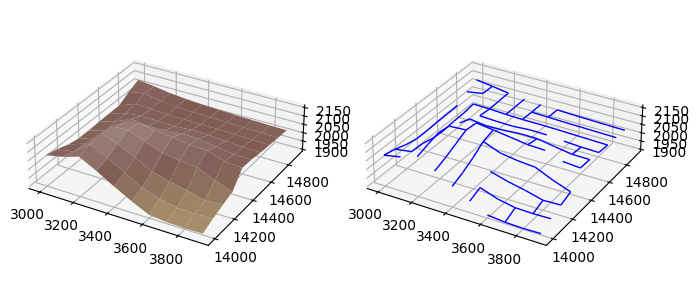

In [ ]:

window = [30, 140, 40, 150]
indices_in_window = vertices[window[0]:window[2], window[1]:window[3]].flatten()

mesh = grid_to_mesh(terrain)
submesh = mesh.subgraph(torch.from_numpy(indices_in_window))
subterrain = submesh.pos.reshape((10, 10, 3))

# Build MST
from networkx import minimum_spanning_tree
nx_submesh = to_networkx(submesh, edge_attrs=['weight'], to_undirected=True)
T = minimum_spanning_tree(nx_submesh)
edges = np.array(T.edges())
tree_seg = submesh.pos[edges]

fig, axs = plt.subplots(1, 2, figsize=(8,4),subplot_kw=dict(projection='3d'))
axs[0].plot_surface(subterrain[:, :, 0], subterrain[:, :, 1], subterrain[:, :, 2], cmap="terrain",
                        rcount=100, ccount=100, norm=norm)
axs[0].set_aspect("equal")

lc = Line3DCollection(tree_seg, colors='blue', linewidths=1)
axs[1].add_collection3d(lc)
axs[1].set_aspect("equal")


In [ ]:
pw_sum = sum(x[2]["weight"] for x in T.edges(data=True)) / 200
beta = np.log(pw_sum) / np.log(2500)
print(f"Power weighted {pw_sum}")
print(f"beta = {beta}")
print(f"estimated dim = {1 / (1 - beta)}")


Power weighted 50.09279491424561
beta = 0.5002369845768991
estimated dim = 2.0009483878141663


Text(0.5, 0.01, 'estimated dim = 2.00727')

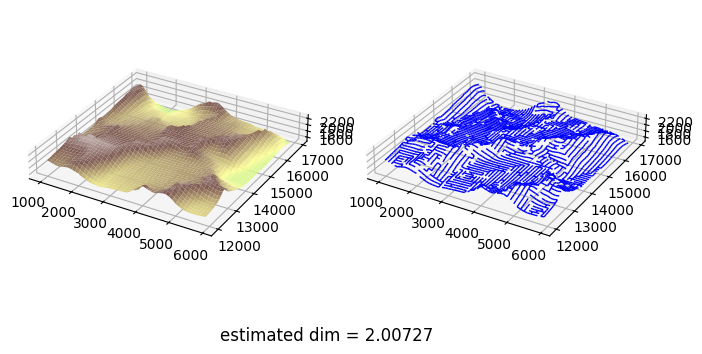

In [21]:

window = [10, 120, 60, 170]
indices_in_window = vertices[window[0]:window[2], window[1]:window[3]].flatten()

mesh = grid_to_mesh(terrain)
submesh = mesh.subgraph(torch.from_numpy(indices_in_window))
subterrain = submesh.pos.reshape((50, 50, 3))

# Build MST
from networkx import minimum_spanning_tree
nx_submesh = to_networkx(submesh, edge_attrs=['weight'], to_undirected=True)
T = minimum_spanning_tree(nx_submesh)
edges = np.array(T.edges())
tree_seg = submesh.pos[edges]

fig, axs = plt.subplots(1, 2, figsize=(8,4),subplot_kw=dict(projection='3d'))
axs[0].plot_surface(subterrain[:, :, 0], subterrain[:, :, 1], subterrain[:, :, 2], cmap="terrain",
                        rcount=100, ccount=100, norm=norm)
axs[0].set_aspect("equal")

lc = Line3DCollection(tree_seg, colors='blue', linewidths=1)
axs[1].add_collection3d(lc)
axs[1].set_aspect("equal")

fig.supxlabel("estimated dim = 2.00727")


In [20]:
pw_sum = sum(x[2]["weight"] for x in T.edges(data=True)) / 5000
beta = np.log(pw_sum) / np.log(2500)
print(f"Power weighted {pw_sum}")
print(f"beta = {beta}")
print(f"estimated dim = {1 / (1 - beta)}")


Power weighted 50.71401174163818
beta = 0.5018122634606357
estimated dim = 2.007275423812013


threshold = 100
62 significant critical point pairs


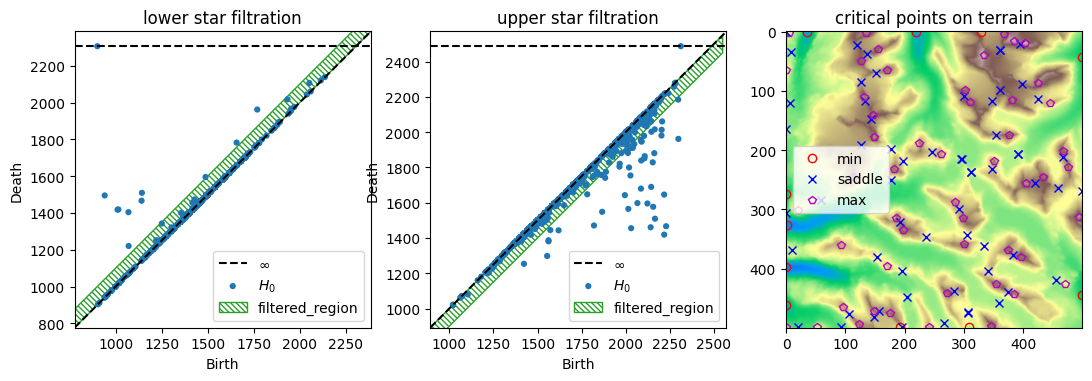

In [22]:
# PH analysis
from data import load_terrain_grid
from ripser import ripser, lower_star_img
from persim import plot_diagrams
threshold = 100
N = 500
terrain = load_terrain_grid(N)
# the original terrain has same-height points we must break the tie
terrain[:, :, 2] += torch.rand((N, N))


lower_dgm = lower_star_img(terrain[:, :, 2])
upper_dgm = - lower_star_img(- terrain[:, :, 2])
long_pers_lower_dgm = lower_dgm[lower_dgm[:, 1]- lower_dgm[:, 0] > threshold]
long_pers_upper_dgm = upper_dgm[upper_dgm[:, 0]- upper_dgm[:, 1] > threshold]
long_pers_dgm = np.concatenate([long_pers_lower_dgm, long_pers_upper_dgm])
print(f"threshold = {threshold}")
print(f"{long_pers_dgm.shape[0]} significant critical point pairs")

fig, axs = plt.subplots(1, 3, figsize=(13,4))

axs[0].set_title("lower star filtration")
plot_diagrams(lower_dgm, ax=axs[0])
x_span = np.linspace(750, 2450, 100)
axs[0].fill_between(x_span, x_span, x_span + threshold, hatch=r"\\\\\\", fc="w", ec="C2", label="filtered_region",zorder=-10)
axs[0].legend()

axs[1].set_title("upper star filtration")
plot_diagrams(upper_dgm, ax=axs[1])
x_span = np.linspace(750, 2550, 100)
axs[1].fill_between(x_span, x_span, x_span - threshold, hatch=r"\\\\\\", fc="w", ec="C2", label="filtered_region",zorder=-10)
axs[1].legend()


axs[2].set_title("critical points on terrain")
axs[2].imshow(terrain[:, :, 2], cmap="terrain", norm=norm, origin="upper")

# find the place of critical points by closest searchin
flatten_terrain = terrain.flatten(0, 1)
critical_idx_0 = [np.argmin(abs(flatten_terrain[:, 2] - long_pers_lower_dgm[i, 0])) for i in range(long_pers_lower_dgm.shape[0])]
critical_idx_2 = [np.argmin(abs(flatten_terrain[:, 2] - long_pers_upper_dgm[i, 0])) for i in range(long_pers_upper_dgm.shape[0])]
critical_idx_1 = [np.argmin(abs(flatten_terrain[:, 2] - long_pers_lower_dgm[i, 1])) for i in range(long_pers_lower_dgm.shape[0])] + \
                [np.argmin(abs(flatten_terrain[:, 2] - long_pers_upper_dgm[i, 1])) for i in range(long_pers_upper_dgm.shape[0])]
critical_idx_1 = list(set(critical_idx_1))

critical_idx_0 = torch.stack(critical_idx_0)
critical_idx_1 = torch.stack(critical_idx_1)
critical_idx_2 = torch.stack(critical_idx_2)

# plot on the terrain
axs[2].plot(critical_idx_0 % N, critical_idx_0 // N, ls="", marker="o", c="none",  mec="r", label="min")
axs[2].plot(critical_idx_1 % N, critical_idx_1 // N, ls="", marker="x", c="none",  mec="b", label="saddle")
axs[2].plot(critical_idx_2 % N, critical_idx_2 // N, ls="", marker="p", c="none",  mec="m", label="max")
axs[2].legend()

In [ ]:
source = critical_idx_2[0].item()

In [ ]:
from networkx import single_source_dijkstra_path_length

terrain = load_terrain_grid(500)
mesh = grid_to_mesh(terrain, add_diag=True)
nx_mesh = to_networkx(mesh, node_attrs=["pos"], edge_attrs=['weight'], to_undirected=True)
source = critical_idx_2[0].item()
distance = single_source_dijkstra_path_length(nx_mesh, source )
distance_mat = torch.FloatTensor([distance[i] for i in range(500 * 500)]).reshape((500, 500))


In [69]:
from model import build_model
from omegaconf import OmegaConf
from tqdm import tqdm
config = "./config/critical_mix_mlp.yaml"
config = OmegaConf.load(config)
model = build_model(config)
model.load_state_dict(torch.load("/data/haoyun/shortest-path/model_cache/critical-mix-mlp/best.pt", map_location="cpu"))
model.requires_grad_(False)
model.eval()
out = []
km_mesh = mesh.clone()
km_mesh.pos = mesh.pos / 1000
for i in tqdm(range(500)):
    batch = (torch.LongTensor([source]).expand((500,)), i * 500 + torch.arange(500),None,  km_mesh)
    out.append(model.predict(batch))
out = torch.stack(out)


100%|██████████| 500/500 [00:14<00:00, 33.51it/s]


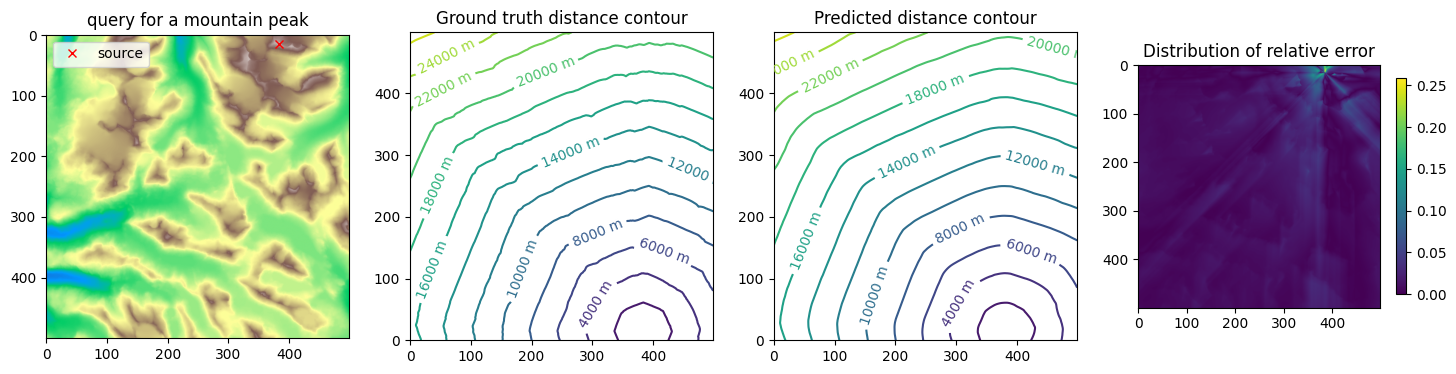

In [74]:
fig, axs = plt.subplots(1, 4, figsize=(18,4))
axs[0].set_title("query for a mountain peak")
axs[0].plot([source % 500], [source // 500], ls="", marker="x", c="r", label="source")
axs[0].imshow(terrain[:, :, 2], cmap="terrain", norm=norm, origin="upper")
axs[0].legend()

axs[1].set_title("Ground truth distance contour")
cntr = axs[1].contour(distance_mat,  levels=15)
axs[1].clabel(cntr, fmt="%.0f m", fontsize=10, use_clabeltext=True)

axs[2].set_title("Predicted distance contour")
cntr = axs[2].contour(out * 1000,  levels=15)
axs[2].clabel(cntr, fmt="%.0f m", fontsize=10, use_clabeltext=True)

axs[3].set_title("Distribution of relative error")
relative_err = abs(distance_mat - out * 1000) / (distance_mat+1e-5)
img = axs[3].imshow(relative_err)
fig.colorbar(mappable=None, cmap=img.cmap, norm=img.norm, ax=axs[3], shrink=0.7)

In [72]:
from data import ShortestPathDataset
random_ds = ShortestPathDataset(path = "/data/haoyun/shortest-path/norway_500x_random_train.pt")
distance_based_ds = ShortestPathDataset(path = "/data/haoyun/shortest-path/norway_500x_distance_train.pt")
critical_based_ds = ShortestPathDataset(path = "/data/haoyun/shortest-path/norway_500x_critical_train.pt")
critical_distance_ds = ShortestPathDataset(path = "/data/haoyun/shortest-path/norway_500x_critical_distance_train.pt")
critical_mix_ds = ShortestPathDataset(path = "/data/haoyun/shortest-path/norway_500x_critical_mix_train.pt")


KeyboardInterrupt: 

(array([ 594., 1722., 2630., 3497., 3975., 4326., 4386., 4558., 4582.,
        4385., 3887., 3284., 2796., 2230., 1490.,  885.,  473.,  199.,
          81.,   20.]),
 array([ 0.        ,  1.45434499,  2.90868998,  4.3630352 ,  5.81737995,
         7.2717247 ,  8.7260704 , 10.18041515, 11.6347599 , 13.08910465,
        14.5434494 , 15.9977951 , 17.45214081, 18.9064846 , 20.36083031,
        21.8151741 , 23.26951981, 24.72386551, 26.1782093 , 27.63255501,
        29.0868988 ]),
 [<matplotlib.patches.Polygon at 0x7f93cbdaca50>])

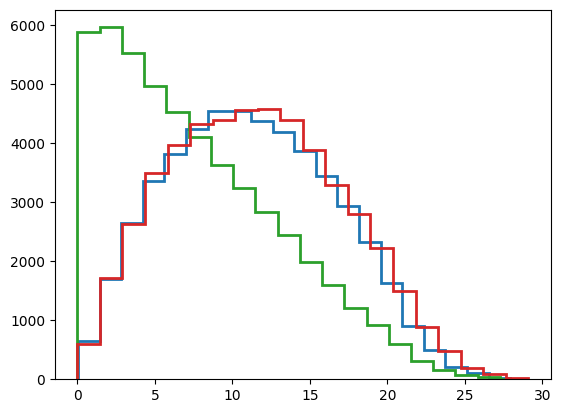

In [ ]:
#fig, axs = plt.subplots(1, 2, figsize=(9, 3))
plt.figure(figsize=(9, 4))
plt.hist(random_ds.distances, bins=20,  edgecolor="C0", linewidth=2, histtype='step', label="random")
plt.hist(distance_based_ds.distances, bins=20, edgecolor="C2", linewidth=2, histtype='step', label="distance-based")
plt.hist(critical_based_ds.distances, bins=20, edgecolor="C3", linewidth=2, histtype='step', label="critical")
plt.hist(critical_distance_ds.distances, bins=20, edgecolor="C4", linewidth=2, histtype='step', label="critical-distance")
plt.hist(critical_mix_ds.distances, bins=20, edgecolor="C5", linewidth=2, histtype='step', label="critical-mix")